# Car battery temperature prediction

#### Libraries and global settings

In [1]:
import os, chardet, glob
import time as tm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mt
import matplotlib.pyplot as plt
import sklearn as skl
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.dummy import DummyRegressor
# import tqdm as tqdm

%matplotlib inline

In [2]:
print(f"numpy version: {np.__version__}")
print(f"pandas version: {pd.__version__}")
print(f"seaborn version: {sns.__version__}")
print(f"matplotlib version: {mt.__version__}")
print(f"sklearn version: {skl.__version__}")

numpy version: 1.21.5
pandas version: 1.4.2
seaborn version: 0.11.2
matplotlib version: 3.5.1
sklearn version: 1.1.3


In [3]:
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 100)

MAIN_COLOR = 'darkochid'

SEED = 42
N_FOLDS = 5

DATA_PATH = './data/'

## Read data

#### Read overview o trips data

In [4]:
df_overview = pd.read_excel(f"{DATA_PATH}Overview.xlsx")
df_overview = df_overview.drop(['Unnamed: 13','Note'], axis=1)
df_overview = df_overview.dropna()
df_overview.rename(columns = {'Unnamed: 8':'SoC difference'}, inplace = True)
df_overview.head(5)

Trip                 Date   Route/Area Weather  \
0  TripA01  2019-06-25_13-21-14  Munich East   sunny   
1  TripA02  2019-06-25_14-05-31  Munich East   sunny   
2  TripA03  2019-06-28_10-02-15  Munich East   sunny   
3  TripA04  2019-06-28_10-13-30  Munich East   sunny   
4  TripA05  2019-06-28_10-20-26  Munich East   sunny   

   Battery Temperature (Start) [°C]  Battery Temperature (End)  \
0                              21.0                       22.0   
1                              23.0                       26.0   
2                              24.0                       25.0   
3                              25.0                       27.0   
4                              27.0                       27.0   

   Battery State of Charge (Start)  Battery State of Charge (End)  \
0                            0.863                          0.803   
1                            0.803                          0.673   
2                            0.835                          0.751   
3                            0.751                          0.667   
4                            0.667                          0.602   

   SoC difference  Ambient Temperature (Start) [°C]  Target Cabin Temperature  \
0           0.060                              25.5                      23.0   
1           0.130                              32.0                      23.0   
2           0.084                              21.5                      27.0   
3           0.084                              24.0                      22.0   
4           0.065                              24.5                      24.0   

   Distance [km]  Duration [min]                 Fan  
0       7.427690       16.820000  Automatic, Level 1  
1      23.509709       23.550000  Automatic, Level 1  
2      12.820846       11.180000  Automatic, Level 1  
3      10.727491        6.870000  Automatic, Level 1  
4      12.393223       22.776667  Automatic, Level 1

In [5]:
df_overview.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70 entries, 0 to 71
Data columns (total 14 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Trip                              70 non-null     object 
 1   Date                              70 non-null     object 
 2   Route/Area                        70 non-null     object 
 3   Weather                           70 non-null     object 
 4   Battery Temperature (Start) [°C]  70 non-null     float64
 5   Battery Temperature (End)         70 non-null     float64
 6   Battery State of Charge (Start)   70 non-null     float64
 7   Battery State of Charge (End)     70 non-null     float64
 8   SoC difference                    70 non-null     float64
 9   Ambient Temperature (Start) [°C]  70 non-null     float64
 10  Target Cabin Temperature          70 non-null     float64
 11  Distance [km]                     70 non-null     float64
 12  Duration [

This data could be useful for enrishing trip data

#### Read trip data
For simplicity purpose only __TripB01__ data used in this project

In [6]:
# def read_trip_data(path=DATA_PATH, mask='*.csv', sep=';'):
#     """Combine all csv datasets into a single file"""
#     df = pd.DataFrame()
#     list_df = []
#     for filename in tqdm.tqdm(glob.glob(f"{path}{mask}")):
#         print(filename)
#         df_trip = pd.read_csv(
#             filename,
#             sep=sep,
#             encoding=chardet.detect(open(filename, 'rb').read())['encoding']
#         )
#         list_df.append(df_trip)
#     df = pd.concat(list_df)
#     return df

In [7]:
filename = f"{DATA_PATH}TripB01.csv"
df_trip = pd.read_csv(
            filename,
            sep=";",
            encoding=chardet.detect(open(filename, 'rb').read())['encoding']
        )
df_trip.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32518 entries, 0 to 32517
Data columns (total 48 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Time [s]                                32518 non-null  float64
 1   Velocity [km/h]                         32518 non-null  float64
 2   Elevation [m]                           32518 non-null  float64
 3   Throttle [%]                            32518 non-null  float64
 4   Motor Torque [Nm]                       32518 non-null  float64
 5   Longitudinal Acceleration [m/s^2]       32518 non-null  float64
 6   Regenerative Braking Signal             32518 non-null  float64
 7   Battery Voltage [V]                     32518 non-null  float64
 8   Battery Current [A]                     32518 non-null  float64
 9   Battery Temperature [°C]                32518 non-null  float64
 10  max. Battery Temperature [°C]           32518 non-null  fl

There is no missing values

In [8]:
df_trip.head(5)

Time [s]  Velocity [km/h]  Elevation [m]  Throttle [%]  Motor Torque [Nm]  \
0       0.0              0.0          449.0           0.0                0.0   
1       0.1              0.0          449.0           0.0                0.0   
2       0.2              0.0          449.0           0.0                0.0   
3       0.3              0.0          449.0           0.0                0.0   
4       0.4              0.0          449.0           0.0                0.0   

   Longitudinal Acceleration [m/s^2]  Regenerative Braking Signal   \
0                           -0.32930                           0.0   
1                           -0.32930                           0.0   
2                           -0.35800                           0.0   
3                           -0.35235                           0.0   
4                           -0.34367                           0.0   

   Battery Voltage [V]  Battery Current [A]  Battery Temperature [°C]  \
0                388.8            -19.06128                       7.0   
1                388.8            -19.06128                       7.0   
2                388.8            -18.86127                       7.0   
3                388.8            -18.69031                       7.0   
4                388.8            -18.64031                       7.0   

   max. Battery Temperature [°C]  SoC [%]  displayed SoC [%]  min. SoC [%]  \
0                            7.0     86.1              100.0             8   
1                            7.0     86.1              100.0             8   
2                            7.0     86.1              100.0             8   
3                            7.0     86.1              100.0             8   
4                            7.0     86.1              100.0             8   

   max. SoC [%)  Heating Power CAN [kW]  Heating Power LIN [W]  \
0            89                     7.0             6860.00000   
1            89                     7.0             6860.00000   
2            89                     7.0             6857.45838   
3            89                     7.0             6837.46138   
4            89                     7.0             6814.95374   

   Requested Heating Power [W]  AirCon Power [kW]  Heater Signal  \
0                   6833.90800                0.0              1   
1                   6833.90800                0.0              1   
2                   6793.90800                0.0              1   
3                   6756.96931                0.0              1   
4                   6737.06980                0.0              1   

   Heater Voltage [V]  Heater Current [A]  Ambient Temperature [°C]  \
0               390.0            17.50000                       8.5   
1               390.0            17.50000                       8.5   
2               390.0            17.50000                       8.5   
3               390.0            17.50000                       8.5   
4               390.0            17.48423                       8.5   

   Ambient Temperature Sensor [°C]  Coolant Temperature Heatercore [°C]  \
0                          9.56344                                  9.0   
1                          9.56344                                  9.0   
2                          9.55939                                  9.0   
3                          9.55066                                  9.0   
4                          9.54193                                  9.0   

   Requested Coolant Temperature [°C]  Coolant Temperature Inlet [°C]  \
0                                  85                             9.0   
1                                  85                             9.0   
2                                  85                             9.0   
3                                  85                             9.0   
4                                  85                             9.0   

   Coolant Volume Flow +500 [l/h]  Heat Exchanger Temperature [°C]  \


## EDA

In [9]:
df_trip.describe()

Time [s]  Velocity [km/h]  Elevation [m]  Throttle [%]  \
count  32518.000000     32518.000000   32518.000000  32518.000000   
mean    1625.850000        42.945591     477.890774     29.624543   
std      938.728236        28.478525       5.296395     18.378355   
min        0.000000         0.000000     449.000000      0.000000   
25%      812.925000        25.937020     478.060707     16.301407   
50%     1625.850000        42.723995     478.868270     33.400000   
75%     2438.775000        57.993015     480.000000     42.501465   
max     3251.700000       150.843750     481.999700     99.395730   

       Motor Torque [Nm]  Longitudinal Acceleration [m/s^2]  \
count       32518.000000                       32518.000000   
mean           11.548483                           0.005745   
std            43.260360                           0.787401   
min           -87.040250                          -3.034850   
25%            -3.500000                          -0.327572   
50%             4.879435                          -0.022000   
75%            21.394613                           0.201540   
max           244.000000                           4.349140   

       Regenerative Braking Signal   Battery Voltage [V]  Battery Current [A]  \
count                  32518.000000         32518.000000         32518.000000   
mean                       0.070265           378.660728           -19.612629   
std                        0.255301             8.056891            51.672483   
min                        0.000000           332.738650          -401.346980   
25%                        0.000000           374.704570           -27.491790   
50%                        0.000000           379.478535            -9.477675   
75%                        0.000000           384.021540            -2.085602   
max                        1.000000           393.947800           135.025910   

       Battery Temperature [°C]  max. Battery Temperature [°C]       SoC [%]  \
count              32518.000000                   32518.000000  32518.000000   
mean                  10.747815                      11.324671     71.650796   
std                    2.400380                       2.702171      8.224463   
min                    7.000000                       7.000000     57.400000   
25%                    8.000000                       8.000000     66.000000   
50%                   11.000000                      12.000000     70.600000   
75%                   12.000000                      13.000000     79.700000   
max                   16.000000                      17.000000     86.100000   

       displayed SoC [%]  min. SoC [%]  max. SoC [%)  Heating Power CAN [kW]  \
count       32518.000000       32518.0       32518.0            32518.000000   
mean           82.933607           8.0          89.0                1.167743   
std            10.728927           0.0           0.0                0.883092   
min            64.500000           8.0          89.0                0.000000   
25%            75.500000           8.0          89.0                0.800000   
50%            81.500000           8.0          89.0                0.960000   
75%            93.500000           8.0          89.0                1.145917   
max           100.000000           8.0          89.0                7.000000   

       Heating Power LIN [W]  Requested Heating Power [W]  AirCon Power [kW]  \
count           32518.000000                 32518.000000       32518.000000   
mean             1179.526009                  1179.660081           0.020547   
std               876.151009                   874.656585           0.133623   
min                 0.000000                     0.000000           0.000000   
25%               840.000000                   840.000000           0.000000   
50%               920.000000                   920.000000           0.000000   
75%              1180.000000                  1199.615520           0.000000   
max      

In [10]:
def plot_dataframe_subplots(df, nrows, ncols, figsize=(30, 24)):
    """Plot a nrows x ncols grid of the df variables
        from: https://www.kaggle.com/code/gitanjali1425/predicting-car-battery-heating-data
    """
    measurements = list(df.columns)
    plt.figure(figsize=figsize)
    for idx, key in enumerate(measurements):
        plt.subplot(nrows, ncols, idx+1)
        plt.plot(np.array(range(df.shape[0]))*0.1, df[key])
        plt.ylabel(key)
        plt.grid(True)
        plt.xlabel(measurements[0])
        plt.show

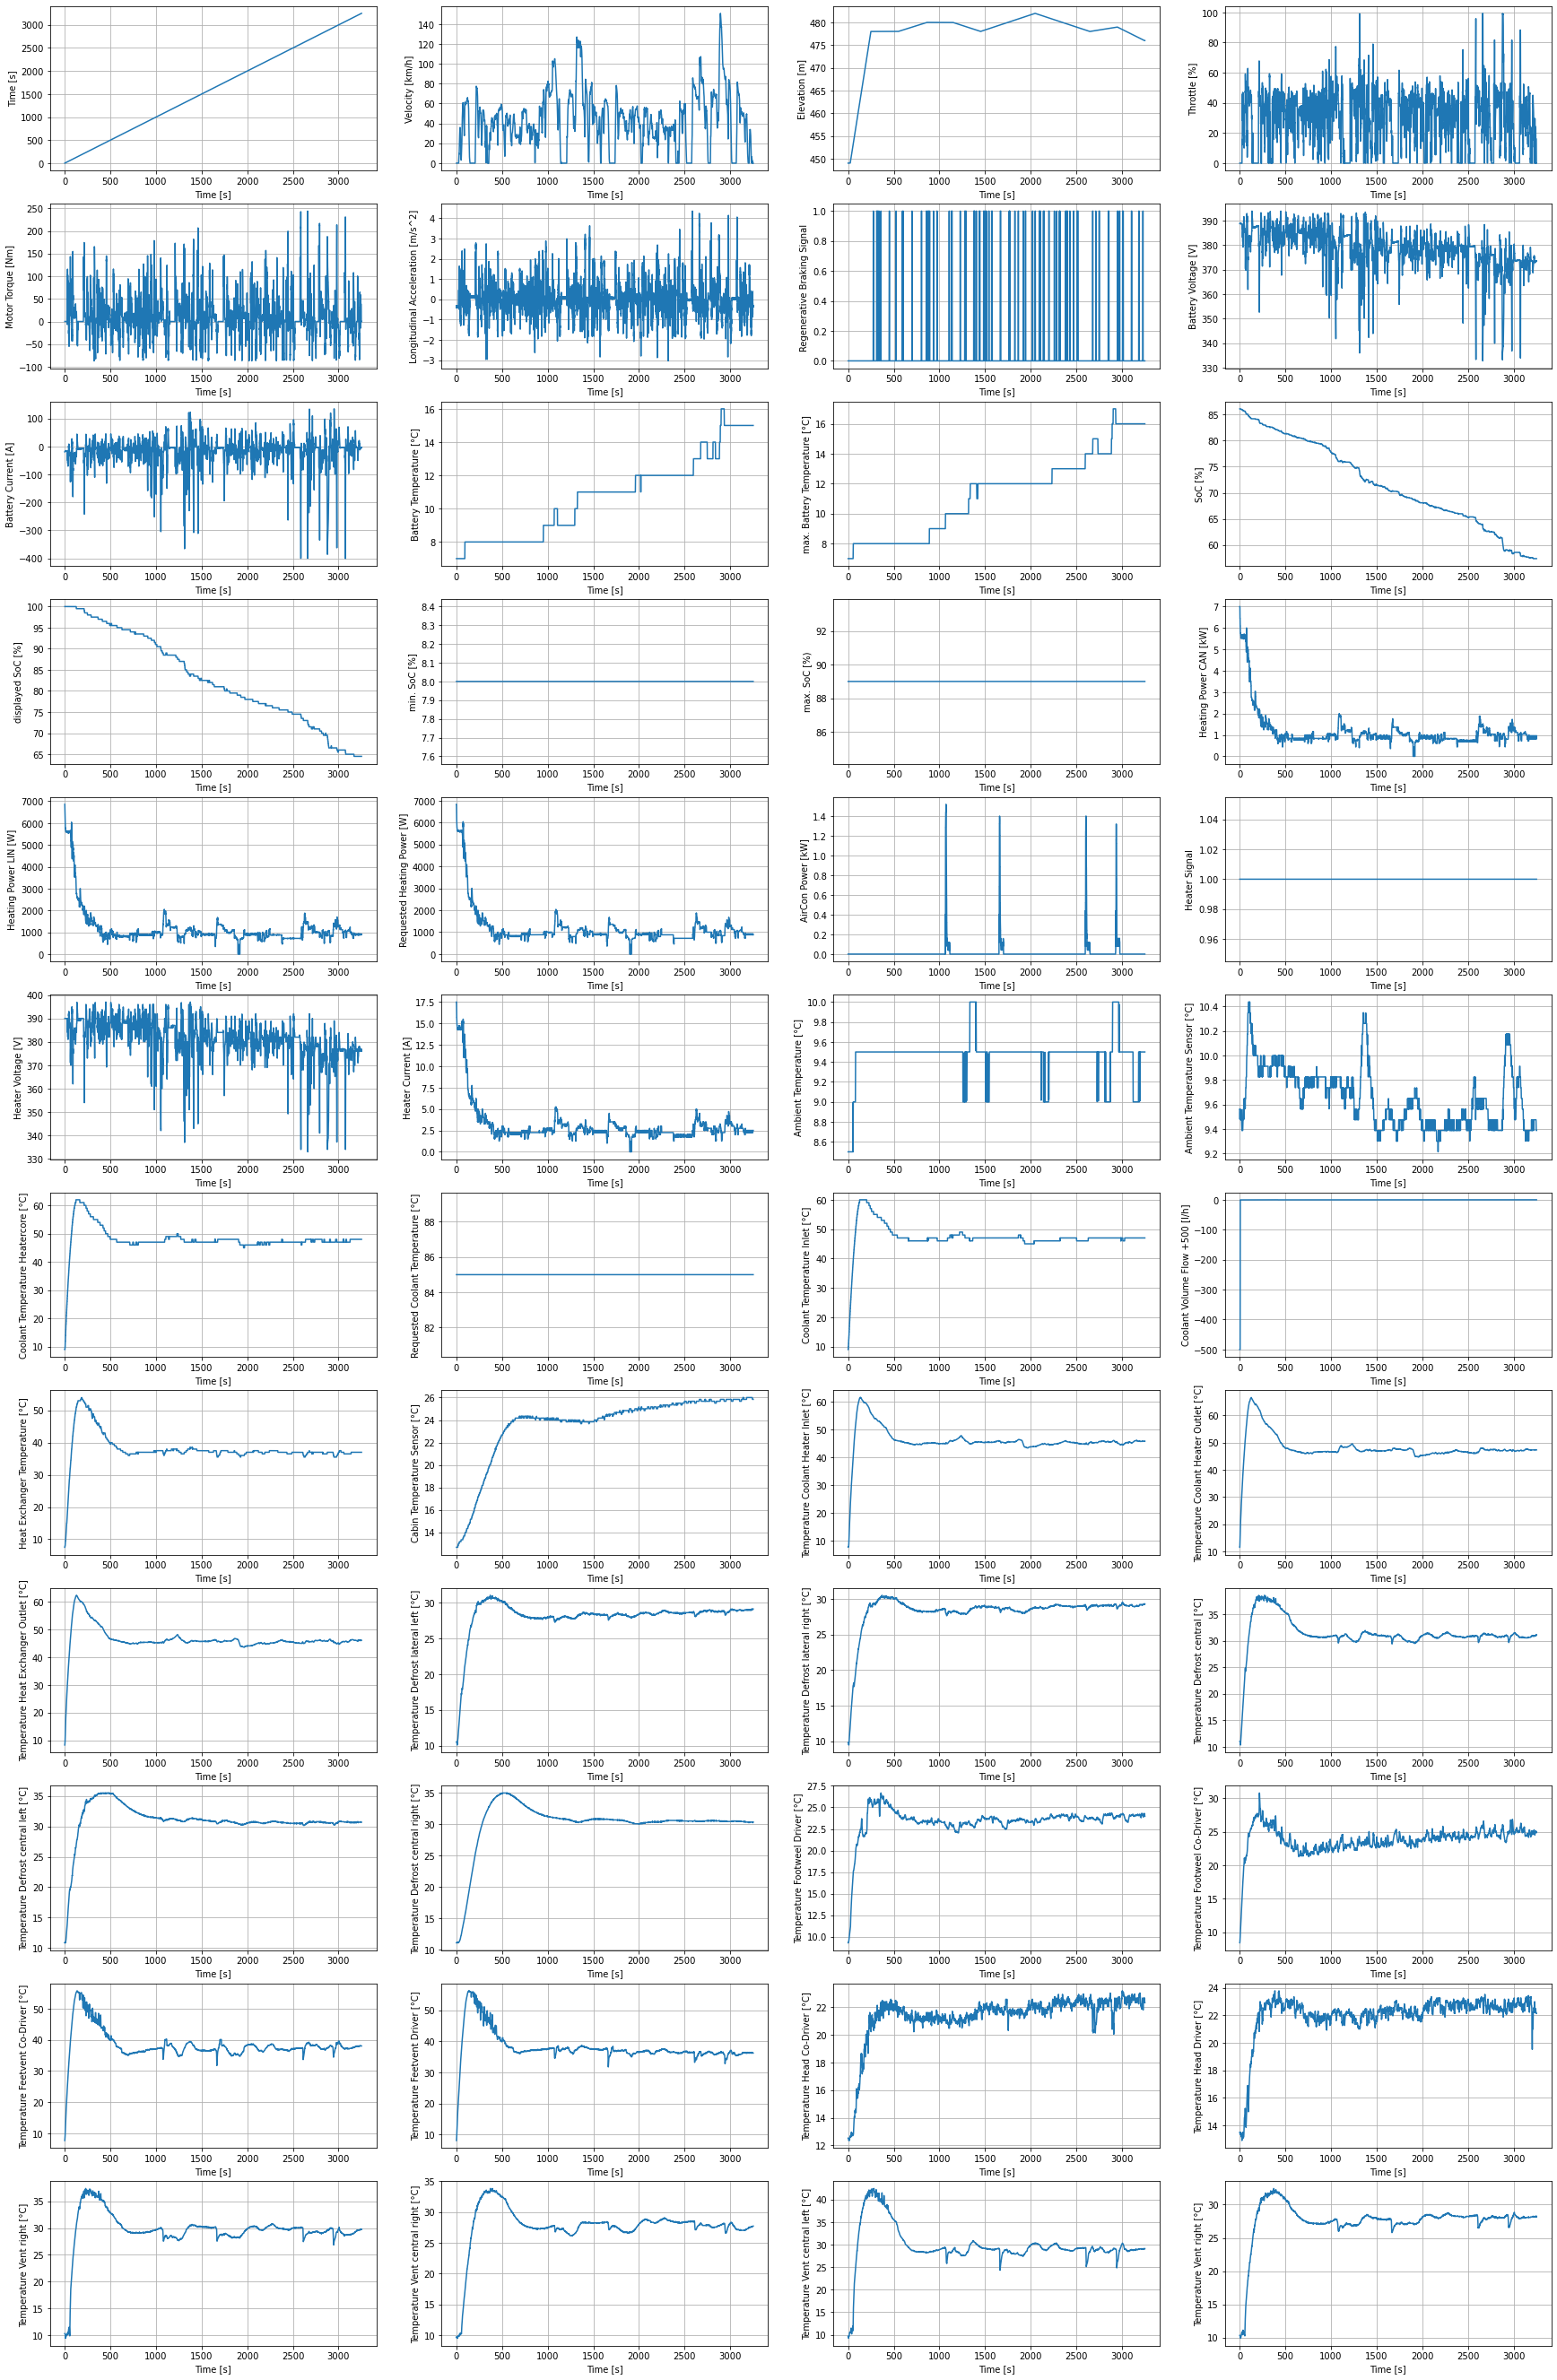

In [11]:
# Plot results of all trips
plot_dataframe_subplots(df_trip, nrows=12, ncols=4, figsize=(30, 48))

Remove from analysis 'Time [s]',n'min. SoC [%]', 'max. SoC [%)', 'Heater Signal', 'Requested Coolant Temperature [°C]', 'Coolant Volume Flow +500 [l/h]', 'Temperature Vent right [°C] '.
Remove 'max. Battery Temperature [°C]' and 'SoC [%]' to prevent target leakage.

In [12]:
TARGET = 'Battery Temperature [°C]'

FEATURES = list(set(df_trip.columns) - set([TARGET,
                                             'Time [s]',
                                             'min. SoC [%]',
                                             'max. SoC [%)',
                                             'Heater Signal',
                                             'Requested Coolant Temperature [°C]',
                                             'Coolant Volume Flow +500 [l/h]',
                                             'Temperature Vent right [°C] ',
                                             'max. Battery Temperature [°C]',
                                             'SoC [%]']))

We observe very strange dependencies so many of features could be useless

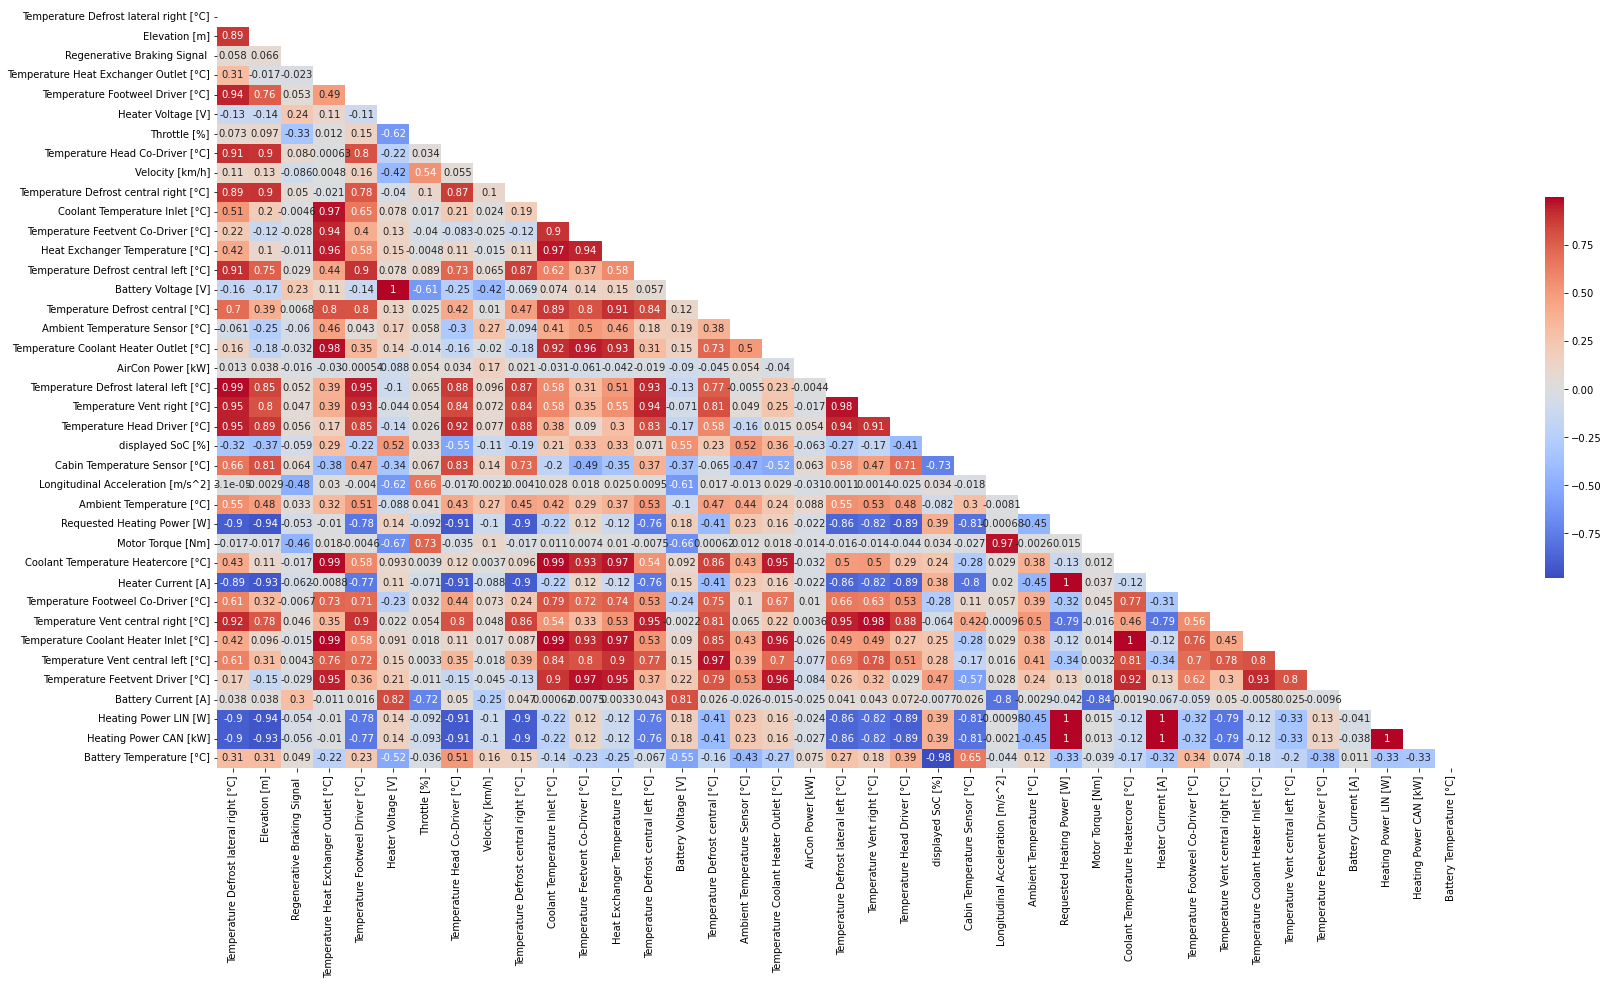

In [13]:
corrMatrix = df_trip[[*FEATURES, TARGET]].corr(method='pearson', min_periods=1)
plt.figure(figsize=(28,14))
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corrMatrix, dtype=bool))
ax = sns.heatmap(corrMatrix, annot=True, mask=mask, cbar_kws={"shrink": .5}, cmap='coolwarm')
plt.show()

Some of features are highly corelated so it's better to delete them

In [14]:
FEATURES = list(set(FEATURES) - set(['Temperature Feetvent Driver [°C]',
                                     'displayed SoC [%]',
                                     'Heating Power LIN [W]',
                                     'Heating Power CAN [kW]',
                                     'Requested Heating Power [W]',
                                     'Coolant Volume Flow +500 [l/h]',
                                     'Longitudinal Acceleration [m/s^2]',
                                     'Temperature Coolant Heater Outlet [°C]',
                                     'Temperature Coolant Heater Inlet [°C]',
                                     'Heater Voltage [V]',
                                     'SoC [%]',
                                     'Temperature Heat Exchanger Outlet [°C]',
                                     'Heat Exchanger Temperature [°C]',
                                     'Coolant Temperature Heatercore [°C]']))

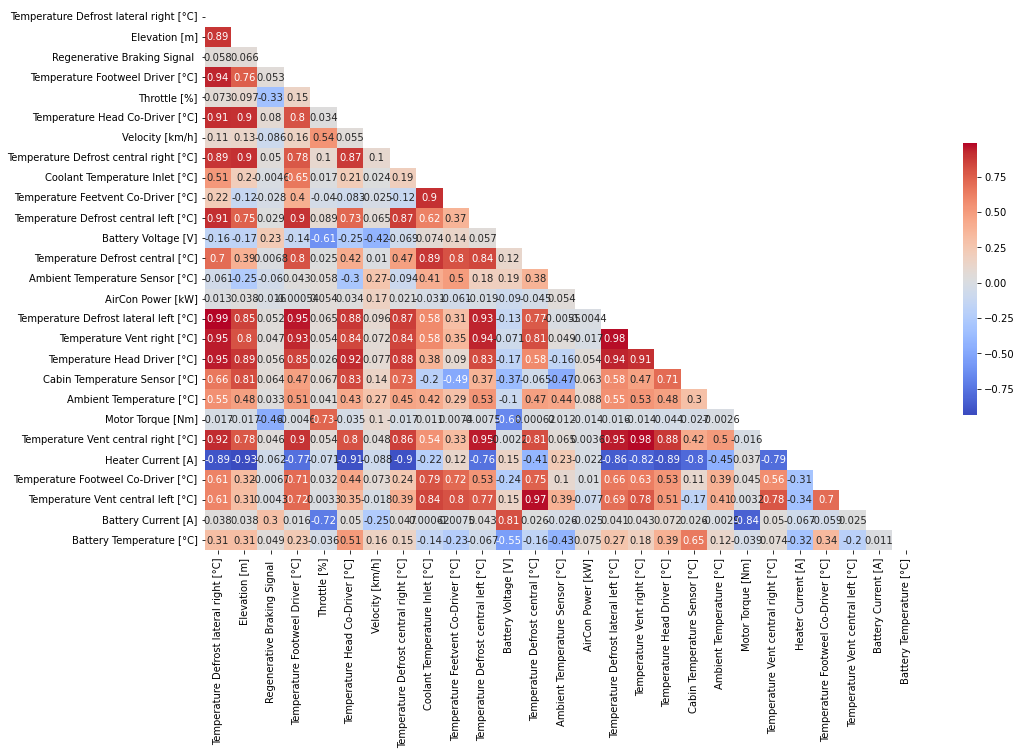

In [15]:
corrMatrix = df_trip[[*FEATURES, TARGET]].corr(method='pearson', min_periods=1)
plt.figure(figsize=(16,10))
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corrMatrix, dtype=bool))
ax = sns.heatmap(corrMatrix, annot=True, mask=mask, cbar_kws={"shrink": .5}, cmap='coolwarm')
plt.show()

#### Pairplots

In [16]:
PAIRPLOT_FEATURES = list(set(FEATURES) - set(['Temperature Vent right [°C]',
                        'Temperature Vent central right [°C]',
                        'Temperature Vent central left [°C]',
                        'Temperature Defrost lateral left [°C]',
                        'Temperature Defrost lateral right [°C]',
                        'Temperature Defrost central right [°C]',
                        'Temperature Defrost central left [°C]']))

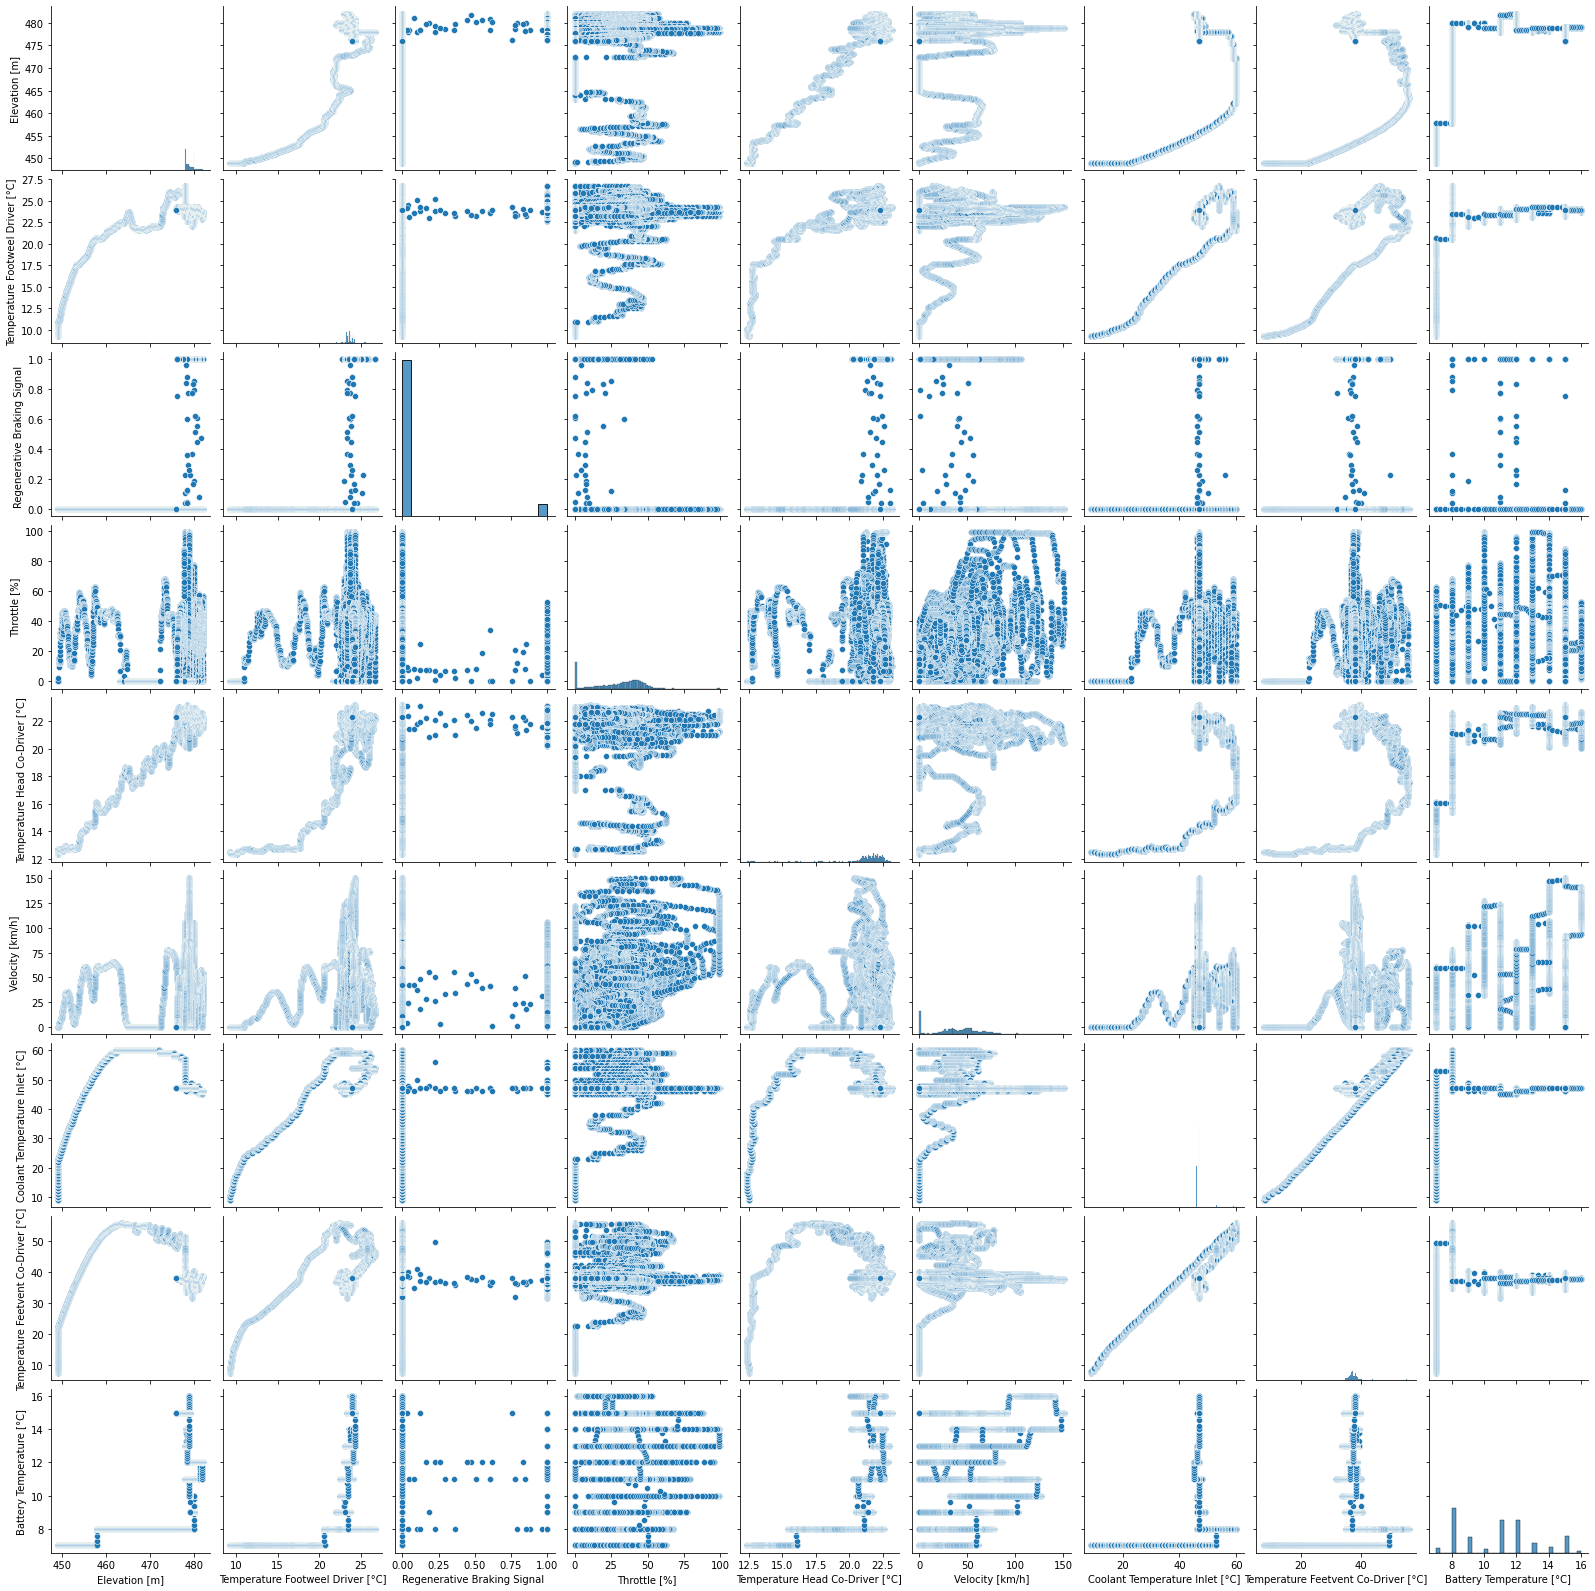

In [17]:
sns.pairplot(df_trip[[
    *PAIRPLOT_FEATURES[:8],
    TARGET
]])

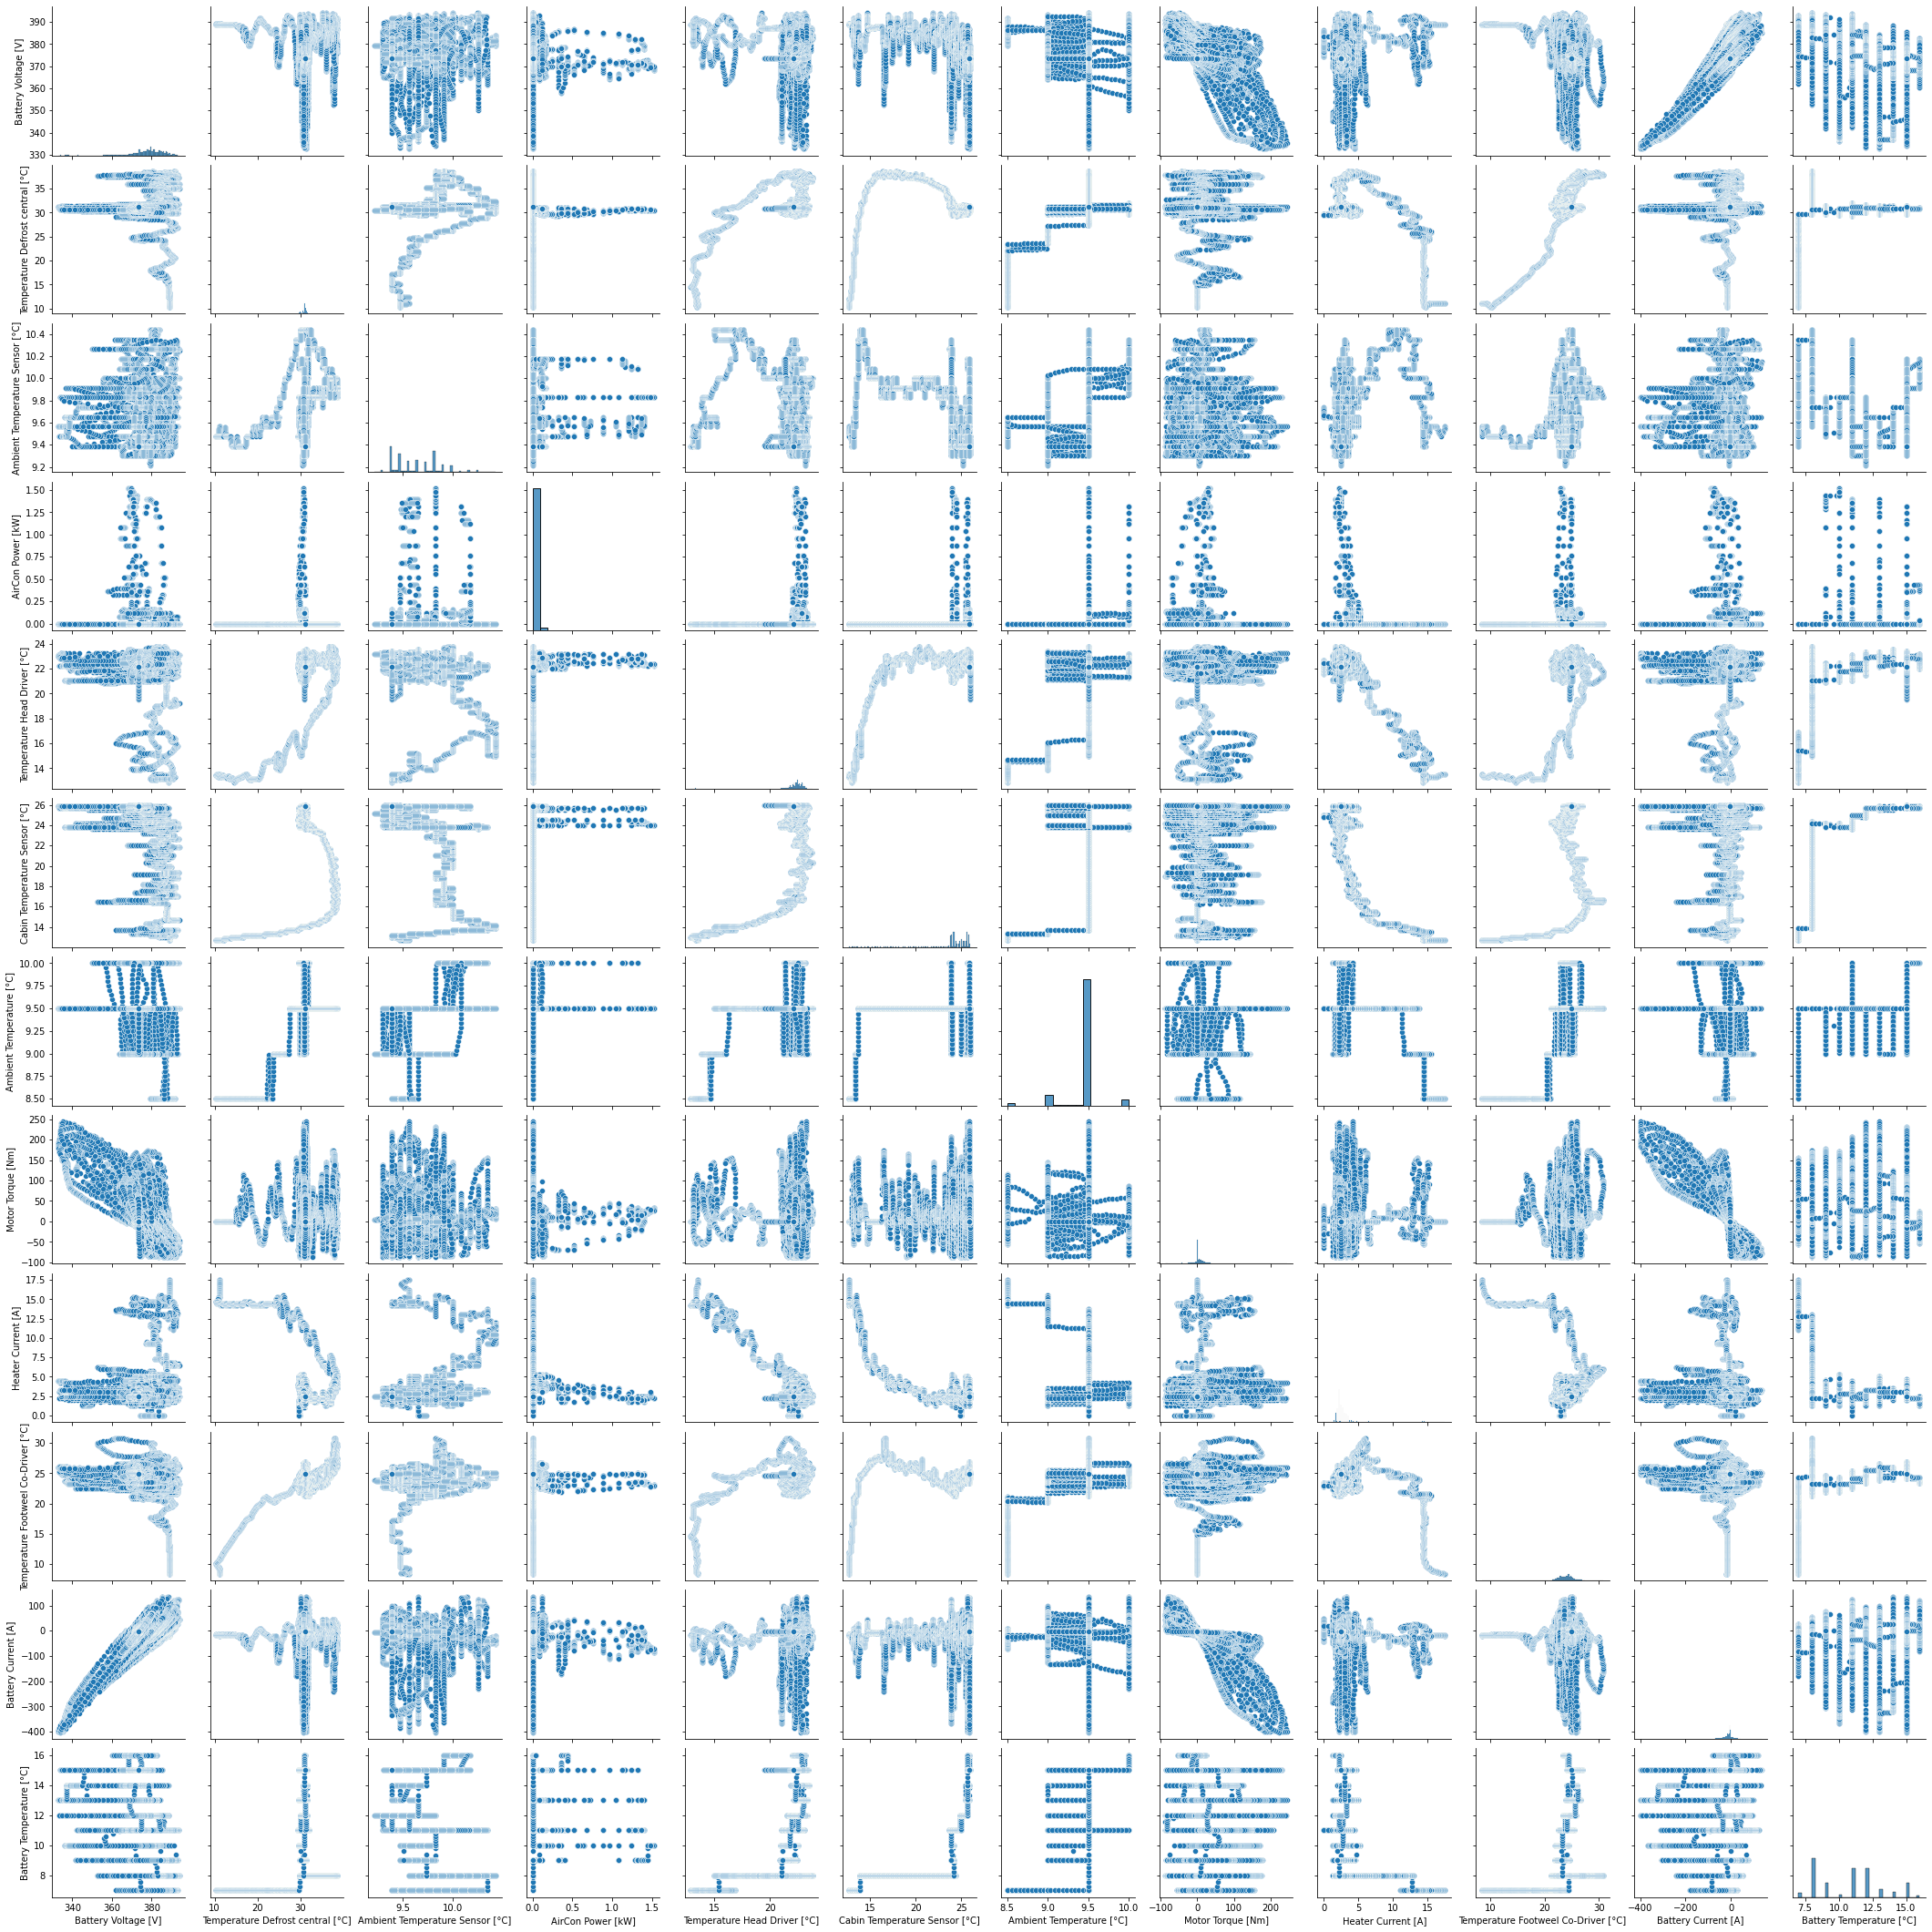

In [18]:
sns.pairplot(df_trip[[
    *PAIRPLOT_FEATURES[8:],
    TARGET
]])

#### Target

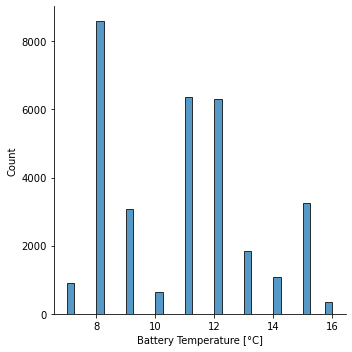

In [19]:
sns.displot(df_trip[TARGET])

## Feature engineering

First of all split data to train and test sets for avoiding leaking

In [20]:
X_train, X_test, y_train, y_test = train_test_split(df_trip[FEATURES], df_trip[TARGET], test_size=0.2, random_state=SEED)

In [21]:
def preprocess(df):
    columns_join = [
        'Temperature Vent right [°C]',
        'Temperature Vent central right [°C]',
        'Temperature Vent central left [°C]',
        'Temperature Defrost lateral left [°C]',
        'Temperature Defrost lateral right [°C]',
        'Temperature Defrost central right [°C]',
        'Temperature Defrost central left [°C]'
    ]

    df['Temperature Vent Defrost'] = df[columns_join].apply(lambda x: max(x), axis=1)
    df = df.drop(columns_join, axis=1)
    
    return df

In [22]:
X_train = preprocess(X_train)

In [23]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

## Model

In [24]:
model_params = {
    'Dummy': {
        'model': DummyRegressor(),
        'params': {
            'strategy': ['mean', 'median']
        }
    },

    'Linear Regression': {
        'model': LinearRegression(),
        'params': {
            'n_jobs': [-1]
        }
    },

    'Ridge': {
        'model': Ridge(),
        'params': {
            'alpha': (0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0)
        }
    },

    'Desicion Tree': {
        'model': DecisionTreeRegressor(), 
        'params' : {
            'criterion': ('squared_error', 'poisson'),
            'max_depth': (5, 6, 7),
            'min_samples_leaf': (2, 4),
            'min_samples_split': (3, 4),
            'random_state': [SEED]
        }  
    },

   'Random Forest': {
       'model': RandomForestRegressor(),
       'params' : {
           'n_estimators': (50, 75, 100, 125, 150),
           'max_depth': [4, 5, 6],
           'min_samples_leaf': (2, 3, 4),
           'min_samples_split': (3, 4),
           'n_jobs': [-1],
           'random_state': [SEED]
       }  
   }, 

    'Ada Boost': {
        'model': AdaBoostRegressor(),
        'params' : {
            'n_estimators': (50, 100, 150, 200, 300),
            'learning_rate': (0.1, 0.2, 0.5, 0.75, 0.9, 1.0, 1.5, 2.0),
            'random_state': [SEED]
        }  
    },
}

In [25]:
for model_name, mp in model_params.items():
    print(model_name)
    start = tm.time()
    clf = GridSearchCV(model_params[model_name]['model'],
                        model_params[model_name]['params'],
                        cv=N_FOLDS,
                        scoring='neg_root_mean_squared_error',
                        return_train_score=False, 
                        n_jobs=-1
    )
    clf.fit(X_train, y_train)
    model_params[model_name]['best_params'] = clf.best_params_
    print(clf.best_params_, clf.best_score_)
    end_time = tm.time() - start
    iter_time = end_time / sum([len(model_params[model_name]['params'][key]) for key in model_params[model_name]['params']])
    print(f"Overal fit time: {end_time:.1f}s  fit time per iter: {iter_time:.1f}s\n")

Dummy
{'strategy': 'mean'} -2.4000887136730364
Overal fit time: 1.5s  fit time per iter: 0.8s

Linear Regression
{'n_jobs': -1} -0.5367506163524364
Overal fit time: 0.6s  fit time per iter: 0.6s

Ridge
{'alpha': 0.1} -0.5367505895548291
Overal fit time: 0.2s  fit time per iter: 0.0s

Desicion Tree
{'criterion': 'poisson', 'max_depth': 7, 'min_samples_leaf': 2, 'min_samples_split': 3, 'random_state': 42} -0.17169003311266173
Overal fit time: 2.0s  fit time per iter: 0.2s

Random Forest
{'max_depth': 6, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 42} -0.20830943541687189
Overal fit time: 437.7s  fit time per iter: 29.2s

Ada Boost
{'learning_rate': 2.0, 'n_estimators': 50, 'random_state': 42} -0.4718597935349301
Overal fit time: 127.5s  fit time per iter: 9.1s



## Test

In [26]:
X_test = preprocess(X_test)
X_test = scaler.transform(X_test)

for model_name, mp in model_params.items():
    print(model_name)
    start = tm.time()
    model = model_params[model_name]['model']
    model.set_params(**model_params[model_name]['best_params'])
    model.fit(X_train, y_train)
    start_predict = tm.time()
    predictions = model.predict(X_test)
    print(f"Fit time: {(tm.time() - start):.3f}s  Predict time: {(tm.time() - start_predict):.3f}s")
    print(mean_squared_error(y_test, predictions, squared=False))
    print('\n')

Dummy
Fit time: 0.001s  Predict time: 0.000s
2.4016947750635262


Linear Regression
Fit time: 0.010s  Predict time: 0.000s
0.5243359449828585


Ridge
Fit time: 0.003s  Predict time: 0.000s
0.5243344424578212


Desicion Tree
Fit time: 0.166s  Predict time: 0.001s
0.16324131931563696


Random Forest
Fit time: 1.025s  Predict time: 0.035s
0.19621229859214073


Ada Boost
Fit time: 2.291s  Predict time: 0.022s
0.47928001453901287




Best model is `Random Forest` despite `Desicion Tree` has better score because Desicion tree is more overtrained.

## Conclusion

Random Forrest as model classifier is best with hyper parameters:
- 'max_depth': 6,
- 'min_samples_leaf': 2,
- 'min_samples_split': 3,
- 'n_estimators': 100,
- 'n_jobs': -1,
- 'random_state': SEED